In [65]:
import librosa
import os
import numpy as np
from tqdm import tqdm


def load_and_process_audio(file_path, max_pad_len=None):
    #load a .wav file with sample rate
    audio, sr = librosa.load(file_path, sr=22050)

    #spectrogram
    S = librosa.feature.melspectrogram(y=audio, sr=sr, n_mels=128, fmax=8000)

    S_db = librosa.power_to_db(S, ref=np.max)

    # padding and tripping the spectrogram
    if max_pad_len:
        # this is just normalizing the length of the spectrogram to the max_pad_len
        pad_width = max_pad_len - S_db.shape[1]
        if pad_width > 0:
            # pads the spectrogram to the right.
            # First two zeros are for the top and bottom of the spectrogram
            S_db = np.pad(S_db, ((0, 0), (0, pad_width)), mode='constant')
        else:
            # keeps all of the rows (first :), comma seperates the rows and columns.
            # so this keeps the first max_pad_len columns, essentially truncating
            # the spectrogram to the max_pad_len
            S_db = S_db[:, :max_pad_len]

    # adds a new axis to the end of the array, turning it from 2D to 3D.
    S_db = S_db[..., np.newaxis]
    return S_db


In [66]:
max_pad_len = 228

In [67]:
import tensorflow as tf

def build_model(input_shape, dimensions, num_classes):
  model = tf.keras.Sequential([
      #here we want to take .wav file spectrogram data and make it into a dimensional space

      #first layer = feature extraction
      #capture low-level feature data like textures
      tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),

      #reduce spatial dimensions for next layer
      tf.keras.layers.MaxPooling2D(pool_size=(2,2)),

      #second round of feature extraction
      # capture more complex spatial features
      tf.keras.layers.Conv2D(64, (3,3), activation="relu"),
      #max pooling again to decrease spatial dims
      tf.keras.layers.MaxPooling2D(pool_size=(2,2)),

      # now it is in the format that we need
      # we need to convert it into a 1d representation
      tf.keras.layers.Flatten(),

      # 1d representation -> embeddings
      # represent embedding as a dimensional vector
      tf.keras.layers.Dense(dimensions, activation='relu'),

      # classify data as one of the 8 classes
      tf.keras.layers.Dense(num_classes, activation='softmax'),
  ])

  return model

In [68]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

directory = '/content/drive/MyDrive/RAVDESS emotional speech'

data = []
labels = []

data = []
labels = []
for subdir in tqdm(os.listdir(directory)):
    subdir_path = os.path.join(directory, subdir)
    if os.path.isdir(subdir_path):
        # walk through all (thanks cursor for the help here)
        for filename in os.listdir(subdir_path):

            file_path = os.path.join(subdir_path, filename)

            if os.path.isfile(file_path) and file_path.endswith('.wav'):
                spectrogram = load_and_process_audio(file_path, max_pad_len)
                # based on filename format from dataset
                emotion = filename.split('-')[2]

                data.append(spectrogram)
                labels.append(emotion)

X = np.array(data)
y = np.array(labels)

X.shape, X[0].shape

100%|██████████| 25/25 [00:06<00:00,  3.91it/s]


((379, 128, 228, 1), (128, 228, 1))

# Data Preprocessing and Encoding

In the cell below, we're performing crucial steps to prepare our data for the model:

1. Label Encoding:
   - We use `LabelEncoder()` from scikit-learn to convert our categorical emotion labels into numerical format.
   - This assigns a unique integer to each distinct emotion label.
   - For example, 'happy' might become 0, 'sad' might become 1, and so on.

2. One-Hot Encoding:
   - After label encoding, we convert the integer labels into one-hot encoded vectors.
   - One-hot encoding creates a binary vector for each sample, where the length of the vector is equal to the number of unique classes.
   - In the vector, all values are 0 except for a single 1 at the index corresponding to the sample's class.
   - For instance, if we have 4 emotions, 'happy' (0) might become [1, 0, 0, 0], 'sad' (1) might become [0, 1, 0, 0], etc.

The intuition behind this approach:
- Label encoding allows us to work with categorical data in a numerical format, which is necessary for most machine learning models.
- One-hot encoding prevents the model from assuming an ordinal relationship between categories (e.g., that 'happy' (0) is somehow less than 'sad' (1)). **Super important**.
- This representation allows the model to treat each emotion as a distinct category.

This is very important as it allows the model to learn the mapping between audio features and emotion categories.



In [74]:
input_shape = (128, max_pad_len, 1)
num_classes = len(np.unique(y_encoded))
dimensions = 256

model = build_model(input_shape, dimensions, num_classes)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(X, y_categorical, epochs=20, batch_size=32)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 323ms/step - accuracy: 0.1303 - loss: 382.8292
Epoch 2/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.1618 - loss: 9.5760 
Epoch 3/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.4850 - loss: 1.5782
Epoch 4/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.8190 - loss: 0.6023
Epoch 5/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.9778 - loss: 0.1568
Epoch 6/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.9953 - loss: 0.0445
Epoch 7/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.9874 - loss: 0.0384
Epoch 8/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.9970 - loss: 0.0290
Epoch 9/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.9920 - loss: 0.0307
Epoch 10/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.9886 - loss: 0.0293
Epoch 11/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.9970 - loss: 0.0141
Epoch 12/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.9943

In [75]:
# Prepare data for PyTorch
input_shape = (1, 128, max_pad_len)
num_classes = len(np.unique(y_encoded))
dimensions = 256

In [76]:
# given in data set
emotion_mapping = {
    1: 'neutral',
    2: 'calm',
    3: 'happy',
    4: 'sad',
    5: 'angry',
    6: 'fearful',
    7: 'disgust',
    8: 'surprised'
}

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


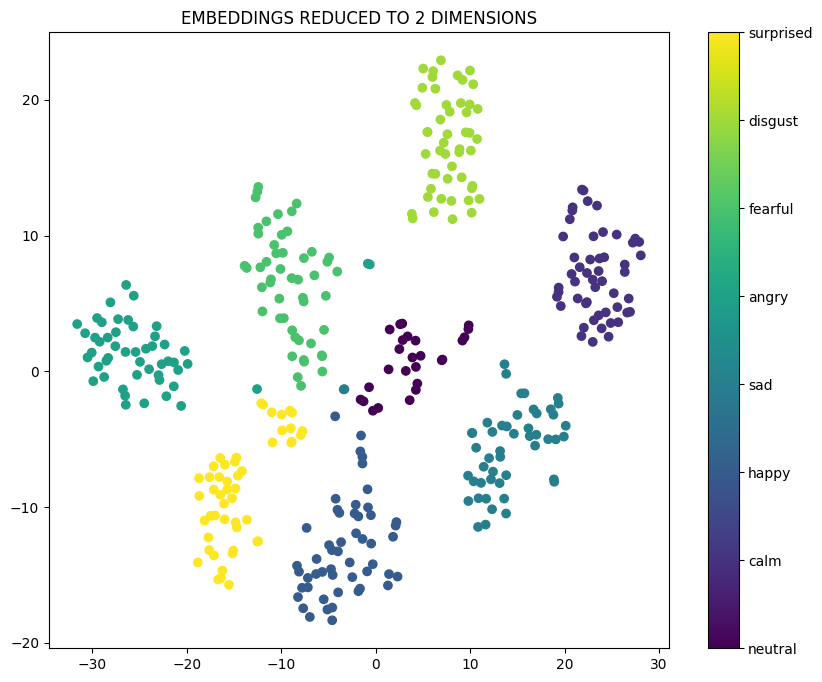

In [77]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.preprocessing import LabelEncoder


# Get input layer and output layer for embeddings
embedding_layer = model.layers[-2].output  # Get the output of the embedding layer

# Create embedding model
embedding_model = tf.keras.Model(inputs=model.inputs, outputs=embedding_layer)
X_embed = embedding_model.predict(X)

# reduce down to 2dim space
tsne = TSNE(n_components=2, random_state=42)
X_reduced = tsne.fit_transform(X_embed)

plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=y_encoded, cmap='viridis')

cbar = plt.colorbar(scatter, ticks=range(len(np.unique(y_encoded))))

cbar.ax.set_yticklabels([emotion_mapping[i] for i in sorted(emotion_mapping)])

plt.title('EMBEDDINGS REDUCED TO 2 DIMENSIONS')
plt.show()

In [80]:
import pandas as pd
import plotly.express as px
from sklearn.manifold import TSNE

# make 3D space
tsne_3d = TSNE(n_components=3, random_state=42)
X_reduced_3d = tsne_3d.fit_transform(X_embed)

# Use emotion_mapping to get emotion labels
fig = px.scatter_3d(
    x=X_reduced_3d[:, 0],
    y=X_reduced_3d[:, 1],
    z=X_reduced_3d[:, 2],
    color=[emotion_mapping.get(i, 'unknown') for i in y_encoded],
    title='3D Mapping Of Audio Embeddings',
    labels={'color': 'Emotion'},
)

fig.update_traces(marker=dict(size=5))
fig.show()